# Introduction

We are proud to share our experience QuEra Computing’s challenge at the ETH Zurich Quantum Hackathon. The event spanned three intense and rewarding days. After the opening keynote, we were introduced to the five available challenges and had the opportunity to briefly visit ETH Zurich’s cutting-edge research facilities. Among the proposed topics, we were particularly drawn to QuEra’s challenge, which focused on optimizing quantum circuits for their neutral-atom quantum computing hardware, a problem that resonated strongly with our background in Computer Engineering and High Performance Computing.

On the second day, we met Pedro Lopes and John Long from the QuEra Computing team, who presented the technical details of the task and provided valuable guidance throughout the competition. Once the challenge was fully explained, the 25-hour countdown began, and so did our focused effort.

This being our first hackathon, we found it deeply educational, technically demanding, and ultimately very fulfilling. What set our team apart, and contributed to our victory was our distinctive approach, shaped by our perspective as computer engineers.

In this post, we share our experience and reflect on the process that led us to our final solution.


# Our Approach

During the initial phase of the challenge, we dedicated our time to understand the provided resources: the detailed challenge description document, associated academic papers, and tutorial notebooks showcasing QuEra’s software tools. This foundational phase was crucial for building a strong conceptual framework.

In subsequent discussions with John and Pedro, we realized there was an opportunity to delve deeper into their software infrastructure. Using built-in debugging features, we explored the internal architecture of their compiler, which allowed us to gain insights and design our own optimization passes.

As we entered the second half of the challenge, we split our efforts into two parallel tasks to maximize efficiency during the intensive overnight session:

- One subgroup focused on developing custom optimization passes.
- The other subgroup worked on manually analyzing and parallelizing circuits.

To objectively evaluate our results, we established a set of clear metrics, prioritized as follows:
1. Fidelity – ensuring that the optimized circuits maintained equivalence to the originals.
2. Parallel CZ gate count – more relevant than U gates due to the higher cost of CZ gates.
3. Parallel U gate count.
4. Sequential CZ gate count.
5. Sequential U gate count.

Ideal optimization corresponds to fidelity close to 1 and minimized gate counts, with a high degree of parallelization.


## Passes

As mentioned earlier, our computer science background played a crucial role in shaping our approach to this challenge, both positively and negatively. Unlike other teams, we dedicated nearly half of the hackathon to thoroughly understanding and exploring the libraries provided. While this initially slowed us down, it ultimately became one of the key reasons for our success.

Rather than focusing solely on manual optimization, we invested significant effort into automating the process. Our goal was not only to solve the specific challenge, but also to develop a scalable method, one that could be generalized and applied to a broader class of quantum circuits.

This mindset led us to design and implement a set of custom optimization passes, extending those already available in the Bloqade library.


Each pass was specifically crafted to address bottlenecks identified during initial profiling of the circuits. 
These passes included:

- Redundant Gate Elimination: removes 2pi gates that are introduced during the internal Rewrite
- U Gate Merge Pass: combines adjacent single-qubit gates to reduce overhead

We also used native passes from the Bloqade library:

- Rydberg Gate Set Rewrite: this pass translates all gates in the given circuits into CZ and U gates (the hardware gate set)
- UOpToParallel: this pass identifies and rewrites gates that can be parallelized

The following code cells allow you to try these passes and freely experiment.

In [18]:
# Run this cell to import the required libraries
import cmath, math
from qiskit import QuantumCircuit

import sys
from pathlib import Path

# Add src folder to import path
current_dir = Path.cwd().resolve()
src_dir = current_dir / 'src'
print(src_dir)
sys.path.append(str(src_dir))

from src import utils
from src import passes
from src import metrics
from src.validate import validate

from kirin.ir.method import Method
from bloqade.qasm2.passes import UOpToParallel

import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk

from bloqade.qasm2.emit import QASM2 as QASM2Target # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer

# These are required to output the QASM after the optimizations
targetParallel = QASM2Target(allow_parallel=True)
targetSequential = QASM2Target(allow_parallel=False)

/home/federico/Desktop/Shared/Projects/ETHQuantumHackaton/src


The following cells allow you to import the QASM files, select the circuit to work on, and inspect the circuit state.

In [19]:
# Run this to import all the QASM files as circuits ready for processing
# Note: you can re-run this later to reset all circuits to their original state
programs = utils.importQASM('inputs')

/home/federico/Desktop/Shared/Projects/ETHQuantumHackaton/inputs
→ /home/federico/Desktop/Shared/Projects/ETHQuantumHackaton/inputs/0.1.qasm parsed & lowered: Method("0.1")
→ /home/federico/Desktop/Shared/Projects/ETHQuantumHackaton/inputs/0.4.qasm parsed & lowered: Method("0.4")
→ /home/federico/Desktop/Shared/Projects/ETHQuantumHackaton/inputs/1.qasm parsed & lowered: Method("1")
→ /home/federico/Desktop/Shared/Projects/ETHQuantumHackaton/inputs/1_improved.qasm parsed & lowered: Method("1_improved")
→ /home/federico/Desktop/Shared/Projects/ETHQuantumHackaton/inputs/1_modified.qasm parsed & lowered: Method("1_modified")
→ /home/federico/Desktop/Shared/Projects/ETHQuantumHackaton/inputs/2.qasm parsed & lowered: Method("2")
→ /home/federico/Desktop/Shared/Projects/ETHQuantumHackaton/inputs/3.qasm parsed & lowered: Method("3")
→ /home/federico/Desktop/Shared/Projects/ETHQuantumHackaton/inputs/3_improved.qasm parsed & lowered: Method("3_improved")
→ /home/federico/Desktop/Shared/Projects/

In [20]:
# Select here the circuit you want to run passes on
# Names range from 1-4, we also made 1_improved, 3_improved and 4_improved
circuit = programs["4_improved"]

# We store the initial qiskit circuit for validation at the end
qc_initial = utils.circuit_to_qiskit(circuit)


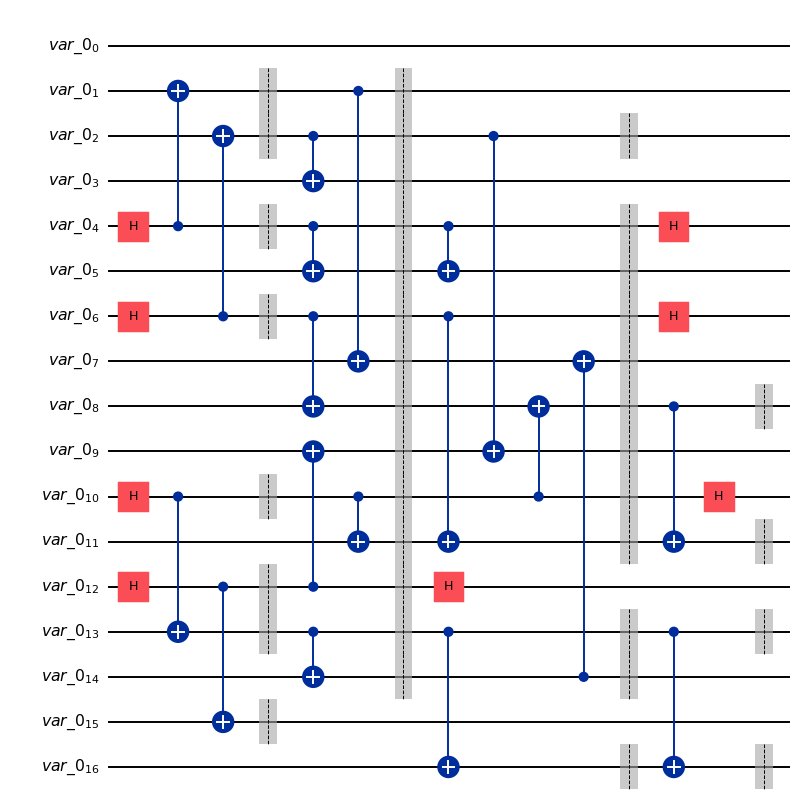

In [21]:
qasm = targetSequential.emit_str(circuit)

fig = QuantumCircuit.from_qasm_str(qasm).draw(output="mpl", fold=120, scale=0.7)
display(fig)

In [22]:
# Run this any time to check the fidelity of the circuit in the current state
# Note: passes apply changes in-place, but we stored the initial state in qc_initial above
qc_current = utils.circuit_to_qiskit(circuit)
validate(qc_initial, qc_current)

⟨sv1|sv2⟩ = (0.9999999999999986+0j)
Fidelity = 0.9999999999999971


np.float64(0.9999999999999971)

In [23]:
# Run this at any time if you want to see the QASM2 (with parallel gates after the UOpToParallel pass!)
# Since the circuit is modified in-place by the passes, you can re-run this after executing passes to see the updated result!
pprint(targetParallel.emit(circuit))

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[17];
h var_0[4];
h var_0[6];
h var_0[10];
h var_0[12];
CX var_0[4], var_0[1];
CX var_0[6], var_0[2];
CX var_0[10], var_0[13];
CX var_0[12], var_0[15];
barrier var_0[1], var_0[4], var_0[2], var_0[6], var_0[10], var_0[13], var_0[12], var_0[15];
CX var_0[2], var_0[3];
CX var_0[1], var_0[7];
CX var_0[4], var_0[5];
CX var_0[6], var_0[8];
CX var_0[12], var_0[9];
CX var_0[10], var_0[11];
CX var_0[13], var_0[14];
barrier var_0[1], var_0[2], var_0[3], var_0[4], var_0[5], var_0[6], var_0[7], var_0[8], var_0[9], var_0[10], var_0[11], var_0[12], var_0[13], var_0[14];
CX var_0[4], var_0[5];
CX var_0[6], var_0[11];
CX var_0[2], var_0[9];
CX var_0[10], var_0[8];
CX var_0[14], var_0[7];
CX var_0[13], var_0[16];
barrier var_0[2], var_0[4], var_0[5], var_0[6], var_0[7], var_0[8], var_0[9], var_0[10], var_0[11], var_0[13], var_0[14], var_0[16];
CX var_0[8],

In [24]:
# This is a duplicate of the previous cell to allow you to compare outputs
pprint(targetParallel.emit(circuit))

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[17];
h var_0[4];
h var_0[6];
h var_0[10];
h var_0[12];
CX var_0[4], var_0[1];
CX var_0[6], var_0[2];
CX var_0[10], var_0[13];
CX var_0[12], var_0[15];
barrier var_0[1], var_0[4], var_0[2], var_0[6], var_0[10], var_0[13], var_0[12], var_0[15];
CX var_0[2], var_0[3];
CX var_0[1], var_0[7];
CX var_0[4], var_0[5];
CX var_0[6], var_0[8];
CX var_0[12], var_0[9];
CX var_0[10], var_0[11];
CX var_0[13], var_0[14];
barrier var_0[1], var_0[2], var_0[3], var_0[4], var_0[5], var_0[6], var_0[7], var_0[8], var_0[9], var_0[10], var_0[11], var_0[12], var_0[13], var_0[14];
CX var_0[4], var_0[5];
CX var_0[6], var_0[11];
CX var_0[2], var_0[9];
CX var_0[10], var_0[8];
CX var_0[14], var_0[7];
CX var_0[13], var_0[16];
barrier var_0[2], var_0[4], var_0[5], var_0[6], var_0[7], var_0[8], var_0[9], var_0[10], var_0[11], var_0[13], var_0[14], var_0[16];
CX var_0[8],

In [25]:
# As for the previous cell, this allows you to see the SSA representation internal to the compiler, in case you're interested
# Note: this is much longer and less intuitive than the QASM2
circuit.print()

func.func 4_improved() -> !py.NoneType {
  ^0():
  │   %0 = py.constant.constant 17 : !py.int
  │   %1 = qasm2.core.qreg.new(n_qubits=%0) : !py.IList[!py.Qubit, !Any]
  │   %2 = py.constant.constant 4 : !py.int
  │   %3 = qasm2.core.qreg.get(reg=%1, idx=%2) : !py.Qubit
  │        qasm2.uop.h(qarg=%3)
  │   %4 = py.constant.constant 6 : !py.int
  │   %5 = qasm2.core.qreg.get(reg=%1, idx=%4) : !py.Qubit
  │        qasm2.uop.h(qarg=%5)
  │   %6 = py.constant.constant 10 : !py.int
  │   %7 = qasm2.core.qreg.get(reg=%1, idx=%6) : !py.Qubit
  │        qasm2.uop.h(qarg=%7)
  │   %8 = py.constant.constant 12 : !py.int
  │   %9 = qasm2.core.qreg.get(reg=%1, idx=%8) : !py.Qubit
  │        qasm2.uop.h(qarg=%9)
  │  %10 = py.constant.constant 4 : !py.int
  │  %11 = qasm2.core.qreg.get(reg=%1, idx=%10) : !py.Qubit
  │  %12 = py.constant.constant 1 : !py.int
  │  %13 = qasm2.core.qreg.get(reg=%1, idx=%12) : !py.Qubit
  │        qasm2.uop.CX(ctrl=%11, qarg=%13)
  │  %14 = py.constant.constant 6 : !py

In [26]:
# Duplicate cell, as before, useful to compare outputs
circuit.print()

func.func 4_improved() -> !py.NoneType {
  ^0():
  │   %0 = py.constant.constant 17 : !py.int
  │   %1 = qasm2.core.qreg.new(n_qubits=%0) : !py.IList[!py.Qubit, !Any]
  │   %2 = py.constant.constant 4 : !py.int
  │   %3 = qasm2.core.qreg.get(reg=%1, idx=%2) : !py.Qubit
  │        qasm2.uop.h(qarg=%3)
  │   %4 = py.constant.constant 6 : !py.int
  │   %5 = qasm2.core.qreg.get(reg=%1, idx=%4) : !py.Qubit
  │        qasm2.uop.h(qarg=%5)
  │   %6 = py.constant.constant 10 : !py.int
  │   %7 = qasm2.core.qreg.get(reg=%1, idx=%6) : !py.Qubit
  │        qasm2.uop.h(qarg=%7)
  │   %8 = py.constant.constant 12 : !py.int
  │   %9 = qasm2.core.qreg.get(reg=%1, idx=%8) : !py.Qubit
  │        qasm2.uop.h(qarg=%9)
  │  %10 = py.constant.constant 4 : !py.int
  │  %11 = qasm2.core.qreg.get(reg=%1, idx=%10) : !py.Qubit
  │  %12 = py.constant.constant 1 : !py.int
  │  %13 = qasm2.core.qreg.get(reg=%1, idx=%12) : !py.Qubit
  │        qasm2.uop.CX(ctrl=%11, qarg=%13)
  │  %14 = py.constant.constant 6 : !py

Below, you can find all the passes. Each cell runs one pass and prints the updated metrics.

In [27]:
# The RydbergRewrite pass modifies the circuit in-place.
# It substitutes each gate with its hardware gate-set equivalent
print("Metrics before RydbergRewrite: ")
metrics.print_gate_counts(targetParallel.emit(circuit))

Walk(RydbergGateSetRewriteRule(circuit.dialects)).rewrite(circuit.code)

print("#"*20)
print("Metrics after RydbergRewrite: ")
metrics.print_gate_counts(targetParallel.emit(circuit))

Metrics before RydbergRewrite: 
parallel CZ: 0
parallel U: 0
other U: 0
other CZ: 0
####################
Metrics after RydbergRewrite: 
parallel CZ: 0
parallel U: 0
other U: 46
other CZ: 19


In [28]:
# The Remove2PiGates pass removes redundant 2pi gates that are introduced during the previous rewrite.
# We use this helper function here to allow easier access to the passes, so you can experiment their effects.
# The full implementation can be found in the footnote
print("Metrics before Remove2PiGates: ")
metrics.print_gate_counts(targetParallel.emit(circuit))

passes.Remove2PiGates(circuit.dialects)(circuit)
metrics.print_gate_counts(targetParallel.emit(circuit))

print("#"*20)
print("Metrics after Remove2PiGates: ")
metrics.print_gate_counts(targetParallel.emit(circuit))

Metrics before Remove2PiGates: 
parallel CZ: 0
parallel U: 0
other U: 46
other CZ: 19
parallel CZ: 0
parallel U: 0
other U: 46
other CZ: 19
####################
Metrics after Remove2PiGates: 
parallel CZ: 0
parallel U: 0
other U: 46
other CZ: 19


In [29]:
# The MergeConsecutiveU pass merges adjacent single-qubit gates to reduce gate count.
# As above, the full implementation is in the footnote
# Note: we recommend running the merge pass *before* UOpToParallel
print("Metrics before MERGE: ")
metrics.print_gate_counts(targetParallel.emit(circuit))

passes.MergeConsecutiveU(circuit.dialects)(circuit)

print("#"*20)
print("Metrics after MERGE: ")
metrics.print_gate_counts(targetParallel.emit(circuit))

Metrics before MERGE: 
parallel CZ: 0
parallel U: 0
other U: 46
other CZ: 19
Running unsafe run MergeConsecutiveU
####################
Metrics after MERGE: 
parallel CZ: 0
parallel U: 0
other U: 46
other CZ: 19


In [30]:
# The UOpToParallel pass optimizes the circuit by parallelizing gates where possible.
print("Metrics before UOpToParallel: ")
metrics.print_gate_counts(targetParallel.emit(circuit))

UOpToParallel(circuit.dialects)(circuit)

print("#"*20)
print("Metrics after UOpToParallel: ")
metrics.print_gate_counts(targetParallel.emit(circuit))

Metrics before UOpToParallel: 
parallel CZ: 0
parallel U: 0
other U: 46
other CZ: 19
####################
Metrics after UOpToParallel: 
parallel CZ: 4
parallel U: 9
other U: 2
other CZ: 1


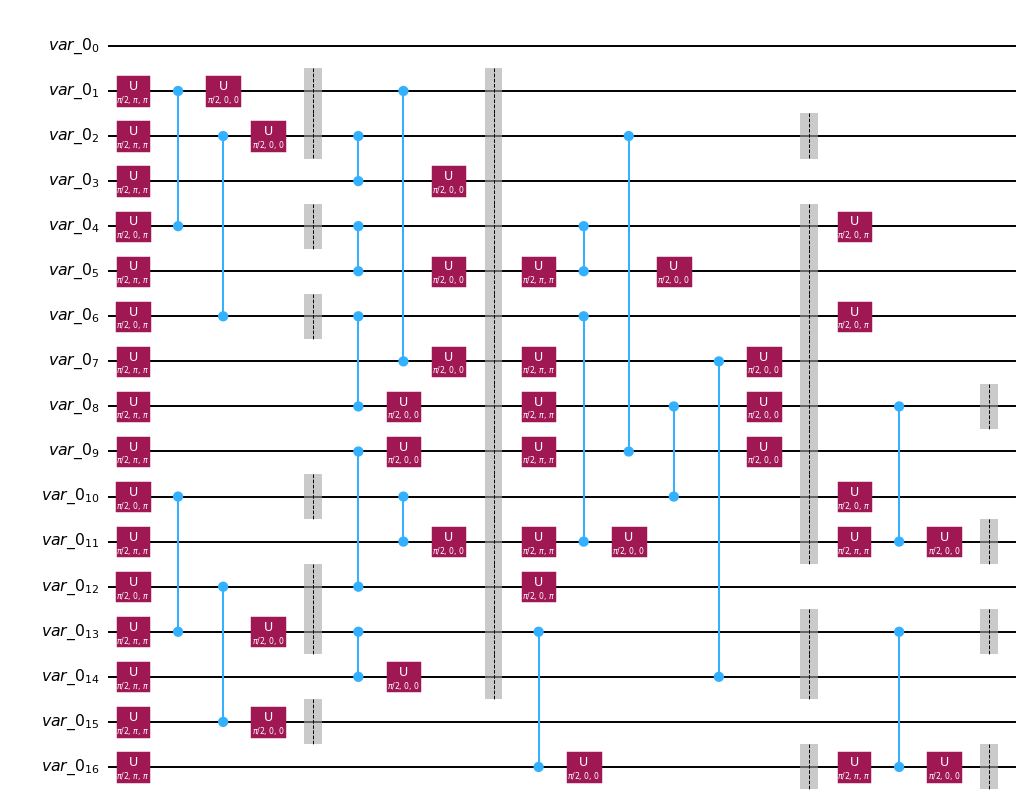

In [31]:
qasm = targetSequential.emit_str(circuit)

fig = QuantumCircuit.from_qasm_str(qasm).draw(output="mpl", fold=120, scale=0.7)
display(fig)

## Manual Optimization

The main point was parallelizing CZ gates thanks to QuEra's unique architecture, but for all the given circuits we adpoted the same approach:

1. Initial inspection to analyze gate dependencies and overall structure 
2. Transformation into an equivalent but more parallel-friendly circuit layout
3. Strategic reordering of gates to maximize parallel execution
4. Careful validation of results by verifying the fidelity between the improved and the original circuits


### Surface Code

To better explain this technique, we present here as an example the job done on circuit number 4 (surface code encoding circuit). 
This is how the initial circuit was like:

<figure>
  <img src="inputs_images/4.png" alt="QFT Circuit" width="500"/>
  <figcaption><em>Figure 1.a: Surface code encoding circuit.</em></figcaption>
</figure>

We begin by identifying five redundant gates—specifically, the initial CNOT gates whose control qubits are in the ∣0⟩ state. These gates have no effect on the quantum state and can therefore be safely removed. The next objective is to reorder the remaining CNOT gates in a way that both preserves the correctness of the circuit and maximizes parallelism. This is crucial, as the target architecture allows for the simultaneous execution of multiple gates in a single time step, provided that no two gates act on the same qubit. Doing this the result obtained was this one:

<figure>
  <img src="inputs_images/4_improved.png" alt="QFT Circuit" width="500"/>
  <figcaption><em>Figure 1.b: Surface code encoding circuit parallelized.</em></figcaption>
</figure>

By examining the updated circuit diagram, we can observe that the entire sequence can now be executed in just four steps. To further assist the optimizer in producing a more efficient layout, we inserted barriers between groups of non-overlapping CNOT gates. These barriers explicitly define sets of operations that can be safely parallelized, improving both the structure and the readability of the circuit.

During the challenge, we realized that circuits of this kind can be parallelized algorithmically. In fact, the entire process can be automated by following these steps:

1. Identify all qubits on which a Hadamard gate is applied.

2. Spot and remove all CNOTs controlled by qubits in state |0>.

3. Track CNOT gate roles, recording for each qubit how many times it acts as a target and with which control qubits it is paired.

4. Reorder CNOT gates, prioritizing two categories of qubits:

    - Qubits that are the target of only one CNOT gate (as they can act as control qubits in later steps),

    - Qubits that are the target of the highest number of CNOT gates (since each targeting requires a distinct step).

5. Insert barriers to define execution layers and enforce parallelism constraints.

For instance, in the optimized version of the circuit, the bottleneck is represented by qubit 11, which is the target of three CNOT gates. However, the first step is allocated to CNOT gates acting on qubits that can serve as control qubits in subsequent layers, thus enabling deeper parallelization later on.
Such a parallelization algorithm can be implemented in several ways:

- Priority queue scheduling of CNOTs  
- Greedy layering approach  
- Integer Linear Programming formulation  
- Graph-coloring-based layer assignment  

As an alternative to this heuristic, one could explore machine-learning schedulers—e.g., reinforcement-learning agents or graph-neural-network models—that learn gate-scheduling policies from data. Such approaches may uncover non-obvious parallelism patterns but require substantial training examples, a simulation environment for reward feedback, and careful integration of hard hardware constraints.

### Quantum Fourier Transform


Another example of manual optimization was in Circuit 1 (QFT). We began by applying a series of manual optimization passes, which we will not examine in detail here for simplicity, but the most significant enhancement comes from the manual transformation of the circuit shown below. Like the Surface Code circuit, the QFT can be seen as an algorithm whose structured dependencies originally limited parallel execution.

#### Circuit after first optimizations 

<figure>
  <img src="inputs_images/1_modified.png" alt="QFT Circuit" width="1000"/>
  <figcaption><em>Figure 2.a: 3 qubits QFT transformed.</em></figcaption>
</figure>

#### Ancilla-Mediated Technique

1. **Ancilla Preparation**  
   - Introduce an ancilla qubit.  
   - Prepare it in the same state as the original control qubit using a small GHZ subcircuit.  

2. **Control Replacement**  
   - For each CNOT (except one) sharing the same original control, switch the control to the ancilla.  
   - Parallelize CNOTs that do not share the control qubit anymore.


The GHZ subcircuit is the parallelized one, below an example of GHZ parallelization

<div style="display: flex; gap: 20px; justify-content: flex-start; align-items: flex-start; margin-left: 40px;">
  <img src="assets/GHZ_linear.png" alt="GHZ Linear" style="height: 300px; display: block;" />
  <img src="assets/GHZ_parallel.png" alt="GHZ Parallel" style="height: 300px; display: block;" />
</div>



#### Optimized Circuit  
<figure>
  <img src="inputs_images/1_improved.png" alt="QFT Circuit" width="1000"/>
  <figcaption><em>Figure 2.b: 3 qubits QFT parallelized.</em></figcaption>
</figure>

By using a single ancilla, we reduce circuit depth and enable parallel application of all target CNOTs. This pattern scales naturally: with *k* ancillae prepared in an *k*-qubit GHZ state, you can redirect *k*–1 controls and execute *k* CNOTs simultaneously. The examples below illustrate this generalization:



<div style="display: flex; gap: 20px; justify-content: center; align-items: flex-start;">
  <figure style="text-align: center; margin: 0;">
    <img src="inputs_images/qft2.png" alt="Original QFT" style="height: 300px; display: block; margin: 0 auto;" />
    <figcaption style="margin-top: 8px;"><em>Figure 3.a: Transformed 5-qubit QFT.</em></figcaption>
  </figure>
  <figure style="text-align: center; margin: 0;">
    <img src="inputs_images/qft2_improved.png" alt="Optimized QFT" style="height: 300px; display: block; margin: 0 auto;" />
    <figcaption style="margin-top: 8px;"><em>Figure 3.b: Parallelized 5-qubit QFT.</em></figcaption>
  </figure>
</div>




# Conclusion

By combining our custom optimization passes with manual parallelization techniques, we achieved results that outperformed either method on their own.

For instance, the improvements in key performance metrics were significant, as described in the following table:

| Metric        | 3q QFT | 3q QFT opt. | 5q QFT | 5q QFT opt. | QAOA | QAOA opt. | Steane | Steane opt. | Surface | Surface opt. |
|:-------------:|:------:|:-----------:|:------:|:-----------:|:----:|:---------:|:------:|:-----------:|:-------:|:------------:|
| Parallel CZ   |   0    |      2      |   0    |      3      |  0   |     0     |   0    |      4      |    0    |      4       |
| Parallel U    |   0    |      4      |   0    |      9      |  0   |    15     |   0    |     16      |    0    |      9       |
| Sequential CZ |  37    |     17      |  54    |     12      | 264  |   189     |  124   |     49      |   84    |      2       |
| Sequential U  |   7    |      3      |  11    |      1      | 36   |    36     |  29    |     21      |   19    |      1       |



These results demonstrate the effectiveness of our approach in reducing depth, minimizing gate count, and maximizing parallel execution. More importantly, the methodology we developed is highly scalable and modular, making it suitable for more complex circuits. Our design also emphasizes the automation of parallelization, a crucial factor for future compiler pipelines targeting hardware with strong architectural constraints.

By combining manual insight with compiler-level tools, we believe our approach offers a promising path toward efficient and hardware-aware quantum circuit optimization.

# Footnote - Passes full implementation

In [32]:
# Required imports
from dataclasses import dataclass
import math

from kirin.passes import Pass

from kirin.rewrite.abc import RewriteRule, RewriteResult
from kirin.rewrite import (
    WrapConst, Walk, 
    Chain, ConstantFold, 
    Fixpoint, DeadCodeElimination, 
    CommonSubexpressionElimination
)

from kirin import ir
from kirin.analysis import const
from bloqade.qasm2.dialects import core, uop, parallel
from kirin.dialects import py as pyDialect

Remove useless gates pass:

In [33]:
@dataclass
class Remove2PiGates(Pass):
    # This function is executed when running the pass
    def unsafe_run(self, method: ir.Method):

        # First remove 2pi constants that are used in U gates 
        # This rewrite also simplifies constants over 2pi to be below 2pi
        result = Walk(Simplify2PiConst()).rewrite(method.code) 

        # Then run an analysis pass to obtain a frame with information on parameter values in all U gates 
        frame, _ = const.Propagate(self.dialects).run_analysis(method)

        # WrapConst inserts the information provided by frame into the gate hints
        result = Walk(WrapConst(frame)).rewrite(method.code).join(result)
        # FindAndSimplifyUGates uses those hints to identify and remove useless gates (those that now have all angles=0)
        result = Walk(FindAndSimplifyUGates()).rewrite(method.code).join(result)
        
        # Finally this rule chain performs common optimizations to clean up  
        rule = Chain(
            ConstantFold(),
            DeadCodeElimination(),
            CommonSubexpressionElimination(),
        )
        result = Fixpoint(Walk(rule)).rewrite(method.code).join(result)
        
        return result

@dataclass
class Simplify2PiConst(RewriteRule):
    eps: float = 1e-11 # IMPORTANT! Not all constants are 100% accurate on 2pi 
    # This eps eases the constraint, to eliminate angles slightly below 2pi as well.
    
    # Integer module function
    def mod(self, a, b):
        if a < b:
            b -= self.eps
        return (a // b) * b
    
    # This function will be called on each statement during the pass
    def rewrite_Statement(self, node: ir.Statement) -> RewriteResult:
        # Only consider constant statements for this rewrite
        if not isinstance(node, pyDialect.Constant):
            return RewriteResult() # Empty result == this rewrite did nothing 
        
        periodicity = 2*math.pi 
        # Search for uses as theta, since that has periodicity of 4pi
        # If the constant is also used as phi or lambda, the 4pi periodicity increase won't affect correctness.
        for use in node.result.uses:
            stmt = use.stmt
            if isinstance(stmt, uop.UGate):
                if(stmt.theta == node.result):
                    periodicity = 4*math.pi

        # Ignore values below the periodicity
        if abs(node.value.unwrap()) < periodicity-self.eps:
            return RewriteResult()

        # Now check if the constant is used in U gates
        # If not, can be left alone
        used_in_U = False
        uses = node.result.uses
        for use in uses:
            if isinstance(use.stmt, uop.UGate):
                used_in_U = True
                break
        
        # Code reaches this point only for constants > periodicity, used in U gates
        if used_in_U: 
            # node.value.unwrap() returns the constant value of the current statement       
            newVal = node.value.unwrap() - self.mod(node.value.unwrap(), periodicity)
            if newVal < 1e-10:
                newVal = 0.0    # Round small values to 0 exactly
            newStmt = pyDialect.Constant(newVal) # Create the new constant statement 
            # Replace the statement. (the internal logic handles the change).
            # node.value should never be changed directly, best treated as a read-only variable
            node.replace_by(newStmt)

            return RewriteResult(has_done_something=True) # Finally, return a non-empty result 
        
        # If constant is never used in U gates 
        return RewriteResult()

@dataclass
class FindAndSimplifyUGates(RewriteRule):
    """
    @brief Deletes all U(0,0,0) gates, using hints to obtain the statements' angle values
    
    Note: const.Propagate and WrapConst() analysis passes should be run before this rewrite,
    as the hints on constants' values are required by this.
    <br>
    Also note: the Simplify2PiConst rewrite should also be run before this rewrite, as this is checking for exact 0 values 

    """
    def rewrite_Statement(self, node: ir.Statement) -> RewriteResult:
        # Only consider UGates for this rewrite
        if not isinstance(node, uop.UGate):
            return RewriteResult()
        
        # We know node is UGate
        # We can find the angle values in the hints thanks to WrapConst() being run before this rewrite in the pass
        theta = node.theta.hints["const"].data
        phi = node.phi.hints["const"].data
        lam = node.lam.hints["const"].data

        # Never delete U gates that apply a non-zero rotation
        if theta != 0 or phi != 0 or lam != 0:
            return RewriteResult()
        
        node.delete() # Delete only U(0,0,0) gates
        return RewriteResult(has_done_something=True)

Merge Consecutive U Gates Pass:

In [34]:
@dataclass
class MergeConsecutiveU(Pass):
    # This function is executed when running the pass
    def unsafe_run(self, method: ir.Method):

        # Iterate analysis pass - gate unification - analysis pass - ... until no change is made
        # Can't use Chain() here as the frame from the analysis pass needs to be passed to WrapConst as parameter each time
        loop_res = RewriteResult(has_done_something=True)
        while loop_res.has_done_something:
            frame, _ = const.Propagate(self.dialects).run_analysis(method)
            Walk(WrapConst(frame)).rewrite(method.code)#.join(result)
            loop_res = Walk(UniteU3()).rewrite(method.code)
        
        # After no more unifications are possible, simplify eventual useless gates 
        # (a merge may have created a gate of 2pi or 0 angle by chance)
        result = Walk(Simplify2PiConst()).rewrite(method.code)#.join(result)
        frame, _ = const.Propagate(self.dialects).run_analysis(method)
        result = Walk(WrapConst(frame)).rewrite(method.code)# .join(result)
        result = Walk(FindAndSimplifyUGates()).rewrite(method.code).join(result)

        # Finally, perform common optimizations to clean up
        rule = Chain(
            ConstantFold(),
            DeadCodeElimination(),
            CommonSubexpressionElimination(),
        )
        result = Fixpoint(Walk(rule)).rewrite(method.code).join(result)
        return result
    
    
@dataclass
class UniteU3(RewriteRule):
    """
    @brief This rewrite identifies and merges consecutive U gates

    Note: const.Propagate and WrapConst() analysis passes should be run before this rewrite,
    as the hints on constants' values are required by this.
    """
    def rewrite_Statement(self, node: ir.Statement) -> RewriteResult:
        if not isinstance(node, uop.UGate):
            return RewriteResult()

        # scan for the very next U on the same qubit
        in_q = node.args[0]
        scan = node.next_stmt
        partner = None
        while scan:
            if in_q in scan.args:
                if isinstance(scan, uop.UGate):
                    partner = scan
                break
            scan = scan.next_stmt
        if partner is None:
            return RewriteResult()

        # pull out the old angles from hints
        θ1,φ1,λ1 = (node.theta.hints["const"].data,
                    node.phi.  hints["const"].data,
                    node.lam.  hints["const"].data)
        θ2,φ2,λ2 = (partner.theta.hints["const"].data,
                    partner.phi.  hints["const"].data,
                    partner.lam.  hints["const"].data)

        # compute the fused triple
        newθ, newφ, newλ = computeProductMatrix(θ1,φ1,λ1, θ2,φ2,λ2)

        # — now do one atomic replacement —
        # 1) build the new Constant statements
        cθ = pyDialect.Constant(newθ.real)
        cφ = pyDialect.Constant(newφ)
        cλ = pyDialect.Constant(newλ)
        # 2) insert them before the old node so they dominate it
        cθ.insert_before(node)
        cφ.insert_before(node)
        cλ.insert_before(node)
        # 3) build your merged UGate
        merged = uop.UGate(in_q, cθ.result, cφ.result, cλ.result)
        # 4) replace the old first node with the merged UGate
        node.replace_by(merged)
        # 5) delete the second node
        partner.delete()

        return RewriteResult(has_done_something=True)
 
def computeProductMatrix(theta1, phi1, lam1, theta2, phi2, lam2):
    # build the entries
    a00 = math.cos(theta1/2)
    a01 = -cmath.exp(1j * lam1) * math.sin(theta1/2)
    a10 =  cmath.exp(1j * phi1) * math.sin(theta1/2)
    a11 =  cmath.exp(1j * (phi1 + lam1)) * math.cos(theta1/2)

    b00 = math.cos(theta2/2)
    b01 = -cmath.exp(1j * lam2) * math.sin(theta2/2)
    b10 =  cmath.exp(1j * phi2) * math.sin(theta2/2)
    b11 =  cmath.exp(1j * (phi2 + lam2)) * math.cos(theta2/2)


    c00 = a00*b00 + a01*b10
    c01 = a00*b10 + a01*b11
    c10 = a10*b00 + a11*b10
    c11 = a10*b01 + a11*b11

    theta3 = 2*cmath.acos(c00)
    sinTheta3 = cmath.sin(theta3/2)
    if sinTheta3 != 0: 
        phi3 = cmath.phase(c10/sinTheta3)
        lam3 = cmath.phase(-c01/sinTheta3)
    else:
        sum_phi_lam3 = cmath.phase(c11/cmath.cos(theta3/2))
        phi3 = 0.0
        lam3 = sum_phi_lam3

    return(theta3, phi3, lam3)

We do not expand on the math of this merge computation in `computeProductMatrix(...)`, but it is obtained considering the U gate definition in the image below.
<br>
<div style="text-align: center">
    <img src="assets/UGateExpansion.png" width=500></img>
</div>